<a href="https://colab.research.google.com/github/yajuna/navier-stokes/blob/master/navier_stokes_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook implements the physics informed neural network methodology proposed by [Raissi et al](https://github.com/maziarraissi/PINNs), and is a Tensorflow 2 modification based on [Jan Blechschmidt and Oliver G. Ernst](https://github.com/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb).

In this notebook, we construct a physics informed neural network to solve the Navier-Stokes equation, and validate the methodology using our own simulated data generated from OpenFoam

This work gives an idea for us to apply the PINN methodology to measured data to compute the solution to Navier-Stokes equation in the future.

### Import libraries. We mainly use Python's `Numpy` library, and the `Tensorflow` library. Visualization is performed by `Matplotlib` library.

In [478]:
import tensorflow as tf
import numpy as np

import pandas
import scipy.io

from time import time

############ visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from scipy.interpolate import griddata
import matplotlib.pylab as plt
############

tf.experimental.numpy.experimental_enable_numpy_behavior()

import sys
print("Python 3 version is", sys.version)
print("Numpy version is", np.__version__)
print("Tensorflow version is", tf.__version__)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)

Python 3 version is 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Numpy version is 1.25.2
Tensorflow version is 2.15.0
Matplotlib version is 3.7.1


## Read generated data by OpenFoam from Google Drive

In [479]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [480]:
%cd /content/drive/My Drive/
# OpenFoam, full
# data = scipy.io.loadmat("data_cube5.mat")
# Openfoam, trimmed
data = scipy.io.loadmat("data_cube_v0509.mat")
# Raissi's original data
# data = scipy.io.loadmat("cylinder_nektar_wake.mat")

/content/drive/My Drive


### Define data type to be `float64`; set random seed for reproducibility.

In [481]:
# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

### Import data files. These data are generated by the OpenFoam CFD software.

The data corresponds to the solution of the Navier-Stokes equation with the following boundary conditions of the [tmin, tmax] by [spacemin,spacemax] domain:

1. left boundary: uniform free stream velocity
2. right boundary: zero pressure outflow, located downstream of the cylinder
3. top and bottom: periodic condition

The notations for the dataset are explained below:

`N`: number of grid points in space
`T`: number of time steps

`U_star`: $x$- component of the velocity field $u$ and $y$- component of the velocity field $v$ values, for all U and T values. Read to `UU` and `VV`, and later reshaped to `u` and `v`. Each of size NT.

`P_star`: pressure $p$ for all N and T. Read to `PP`, then reshaped to `p`. Each of size NT.

`t`: time where data are recorded, of size T. Broadcasted to size NT.

`X_star`: spatial variables where data are recorded, including both $x$ and $y$. Read to `XX` and `YY`, then reshaped to `x` and `y`. Each broadcasted to size NT.

Training data was labeled `*_train`, with spatial, temporal, as well as velocity and pressure data. The training data was chosen randomly from the full dataset explained above, of size `N_train`.

Testing data was labeled `*_star`, chosen at a time step `snap`.

Input of the neural network is `X_train` and `data_train`, with $x$, $y$, and $t$ variables, as well as $u$, $v$, and $p$. Testing data is similar.

Training data consist of 5000 data points, chosen from NT points, denoted by `N_train`. Testing data was chosen at a random time snap, denoted by `snap`.

In [482]:
N_train = 50
Num_layer = 4
Epoch = 500

# define training and testing data
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t.shape[0]

print('Size of x: N and size of t: T', N, T)
print('Range of U_star, P_star, t, X_star', U_star.min(), U_star.max(), P_star.min(), P_star.max(), t.min(), t.max(), X_star.min(), X_star.max())

#tile independent variable Data (like meshgrid) to size N by T
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

############################################################
######################## Data ##############################
############################################################
# Training Data
idx = np.random.choice(N*T, N_train, replace=False)
print('min idx is', idx.min(), "max idx is", idx.max())

x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]

u_train = u[idx,:]
v_train = v[idx,:]
p_train = p[idx,:]


# make training data
X_train = tf.concat([x_train,y_train,t_train], axis = 1)
data_train = tf.concat([u_train,v_train,p_train], axis = 1)

print(np.min(YY), np.max(YY), np.min(XX), np.max(XX))

Size of x: N and size of t: T 8990 149
Range of U_star, P_star, t, X_star -0.57702 1.4437 -0.5035 0.66001 7599 29651 -15.0 15.0
min idx is 17360 max idx is 1312627
-4.0 4.0 -15.0 15.0


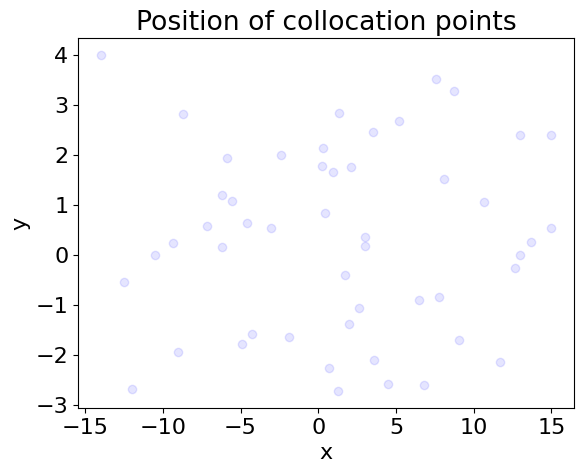

In [483]:
# plot allocation of points

x = x_train
y = y_train

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, color='blue', alpha=0.1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Position of collocation points')

plt.savefig('collocation_points.eps', bbox_inches='tight', dpi=300)
plt.show()

### We define the residual of the PDE. The physics information is given by the governing Navier-Stokes equations:

$u_t+1(uu_x + vu_y)=-p_x+0.01(u_{xx}+u_{yy})$

$v_t+1(uv_x + vv_y)=-p_y+0.01(v_{xx}+v_{yy})$,

here $(x,y)$ denotes the spatial variable, $t$ the temporal variable, $u(t,x,y)$ denotes the $x$-component of the velocity field, $v(t,x,y)$ the y-component, and $p(t,x,y)$ the pressure.

We include the following errors in the loss term of the neural network

$f = u_t+1(uu_x + vu_y)+p_x-0.01(u_{xx}+u_{yy})$

$g = v_t+1(uv_x + vv_y)+p_y-0.01(v_{xx}+v_{yy})$,

and we train the neural network by minimizing the loss including the above terms.



In [484]:
# Define residual of the PDE
def fun_r(u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y):
  f = (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy) + u_t
  g = (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy) + v_t
  print('tf.concat([f,g], axis = 1).shape', tf.concat([f,g], axis = 1).shape)
  return tf.concat([f,g], axis = 1)

Initialize the neural network; by default, the neural network has 8 hidden layers, and 20 neurons on each layer.



In [485]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is three-dimensional (time + two spatial dimensions)
    model.add(tf.keras.Input(3))

    # Define lower boundary and upper boundary
    x = X_train[:,0:1]
    y = X_train[:,1:2]
    t = X_train[:,2:3]
    lb = tf.constant([np.array(x.min()), np.array(y.min()), np.array(t.min())])
    ub = tf.constant([np.array(x.max()), np.array(y.max()), np.array(t.max())])


    # Introduce a scaling layer to map input from [lb, ub] to [-1,1]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is two-dimensional: psi and p
    model.add(tf.keras.layers.Dense(2))

    return model

In [486]:
def get_r(model, X_train):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x, y, t = X_train[:, 0:1], X_train[:,1:2], X_train[:,2:3]

        # Variables x,y,t are watched during tape
        # to compute derivatives
        tape.watch(x)
        tape.watch(y)
        tape.watch(t)

        # Determine residual
        pp = model(tf.stack([x[:,0],y[:,0],t[:,0]], axis=1))
        psi = pp[:,0:1]
        p = pp[:,1:2]
        # Compute gradients within the GradientTape
        # for all needed derivatives
        u = tape.gradient(psi, y)
        # print("max and min of u", u.max, u.min)
        v = -1 * tape.gradient(psi, x)
        # print("type of v", type(v))
        u_x = tape.gradient(u, x)
        # print("max and min of u_x", u_x.max, u_x.min)
        u_y = tape.gradient(u, y)
        # print("max and min of u_y", u_y.max, u_y.min)
        v_x = tape.gradient(v, x)
        # print("max and min v_x", v_x.max, v_x.min)
        v_y = tape.gradient(v, y)



    p_x = tape.gradient(p, x)
    p_y = tape.gradient(p, y)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)

    v_t = tape.gradient(v, t)
    v_xx = tape.gradient(v_x, x)
    v_yy = tape.gradient(v_y, y)

    del tape

    return fun_r(u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y)

In [487]:
def compute_loss(model, X_train, data_train):

    # Compute phi^r
    r = get_r(model, X_train)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss with physics loss
    loss = phi_r

    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x, y, t = X_train[:, 0:1], X_train[:,1:2], X_train[:,2:3]

        # Variables x,y,t are watched during tape
        # to compute derivatives
        tape.watch(x)
        tape.watch(y)
        tape.watch(t)

        # Determine residual
        pp = model(tf.stack([x[:,0],y[:,0],t[:,0]], axis=1))
        psi = pp[:,0:1]
    p = pp[:,1:2]
##########
    u = tape.gradient(psi, y)
    v = -1 * tape.gradient(psi, x)
    del tape

    # Concatenate u, v, and p along with p to match the shape of data_train
    data_pred = tf.concat([u, v, p], axis=1)

    loss += tf.reduce_mean(tf.square(data_train[:,0:1] - data_pred[:,0:1]))
    loss += tf.reduce_mean(tf.square(data_train[:,1:2] - data_pred[:,1:2]))
    loss += tf.reduce_mean(tf.square(data_train[:,2:3] - data_pred[:,2:3]))
    return loss


In [488]:
def get_grad(model, X_train, data_train):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_train, data_train)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [489]:
# Initialize model aka u_\theta
model = init_model(num_hidden_layers=Num_layer)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

## Print model summary
# model.summary()
# tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True,
#                           show_layer_names=True, show_dtype=True,
#                           show_layer_activations=True)

In [490]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_train, data_train)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = Epoch
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

tf.concat([f,g], axis = 1).shape (50, 2)
tf.concat([f,g], axis = 1).shape (50, 2)
It 00000: loss = 1.43084064e+00
It 00050: loss = 1.47962117e-01
It 00100: loss = 7.36726275e-02
It 00150: loss = 2.25656235e-02
It 00200: loss = 5.54259302e-03
It 00250: loss = 2.56148829e-03
It 00300: loss = 1.58846577e-03
It 00350: loss = 1.12951261e-03
It 00400: loss = 9.47926759e-04
It 00450: loss = 7.06918299e-04
It 00500: loss = 6.55014021e-04

Computation time: 14.736969709396362 seconds


In [491]:
model.save("navier-stokes-pinn.keras")

# Visualization

## Plot loss

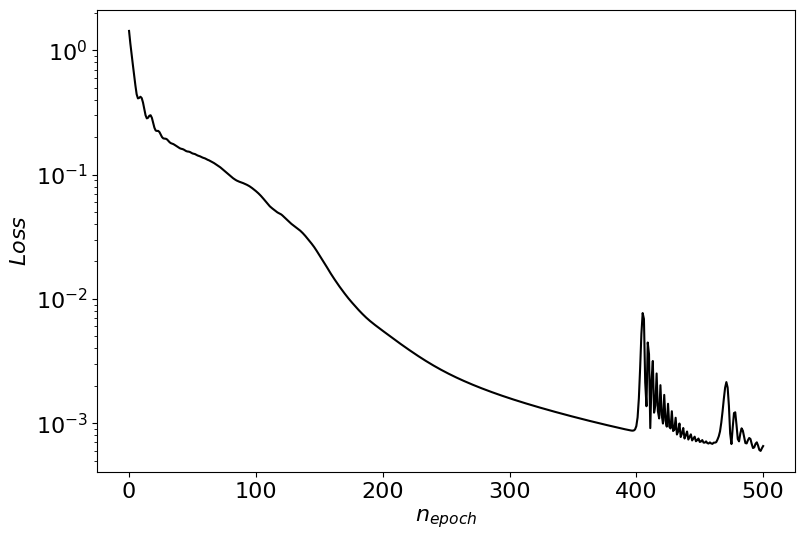

In [492]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 16})
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$Loss$');
plt.savefig('figure_loss.eps', bbox_inches='tight', dpi=300);

## After the neural network is trained, we test the neural network with other data of Navier-Stokes equations, as they obey the same PDEs, and therefore have the same loss function.

In [493]:
## import testing data- a new set that the PINN has not seen.

data1 = scipy.io.loadmat("data_cube5.mat")
# data1 = scipy.io.loadmat("data_cube_v0509.mat")

# define training and testing data
U_star1 = data1['U_star'] # N x 2 x T
P_star1 = data1['p_star'] # N x T
t1 = data1['t'] # T x 1
X_star1 = data1['X_star'] # N x 2

N1 = X_star1.shape[0]
T1 = t1.shape[0]

print('Size of traing x: N and size of t: T', N1, T1)

TT1 = np.tile(t1, (1,N1)).T # N x T

# Test Data -- used in model.predict to test model
snap1 = np.array([95])
x_star1 = X_star1[:,0:1]
y_star1 = X_star1[:,1:2]
t_star1 = TT1[:,snap1]
print("Shapes of testing data", x_star1.shape, y_star1.shape, t_star1.shape)

u_star1 = U_star1[:,0,snap1]
v_star1 = U_star1[:,1,snap1]
p_star1 = P_star1[:,snap1]

# make testing data

X_test1 = tf.concat([x_star1,y_star1,t_star1], axis = 1)
data_test1 = tf.concat([u_star1,v_star1,p_star1], axis = 1)

Size of traing x: N and size of t: T 23768 100
Shapes of testing data (23768, 1) (23768, 1) (23768, 1)


In [494]:
with tf.GradientTape(persistent=True) as tape:

  x1,y1,t1 = X_test1[:,0:1], X_test1[:,1:2], X_test1[:,2:3]
  tape.watch(x1)
  tape.watch(y1)
  tape.watch(t1)
  data_pred1 = model(tf.stack([x1[:,0],y1[:,0],t1[:,0]], axis=1))
  psi_pred1 = data_pred1[:,0:1]
p_pred1 = data_pred1[:,1:2]
u1 = tape.gradient(psi_pred1, y1)
v1 = -1 * tape.gradient(psi_pred1, x1)
data_pred1 = tf.concat([u1,v1,p_pred1], axis = 1)

In [495]:
print("size of predicted and measured data", data_test1.shape, data_pred1.shape)

error1 = 0
error1 += tf.reduce_mean(tf.square(data_test1[:,0:1] - data_pred1[:,0:1]))
error1 += tf.reduce_mean(tf.square(data_test1[:,1:2] - data_pred1[:,1:2]))
error1 += tf.reduce_mean(tf.square(data_test1[:,2:3] - data_pred1[:,2:3]))
print("reduced mean square of testing error", error1)

size of predicted and measured data (23768, 3) (23768, 3)
reduced mean square of testing error tf.Tensor(0.13548454955555908, shape=(), dtype=float64)


X.shape =  (23768, 1)
Y.shape =  (23768, 1)
Z_pred.shape =  (23768, 1)
Z_test.shape =  (23768, 1)


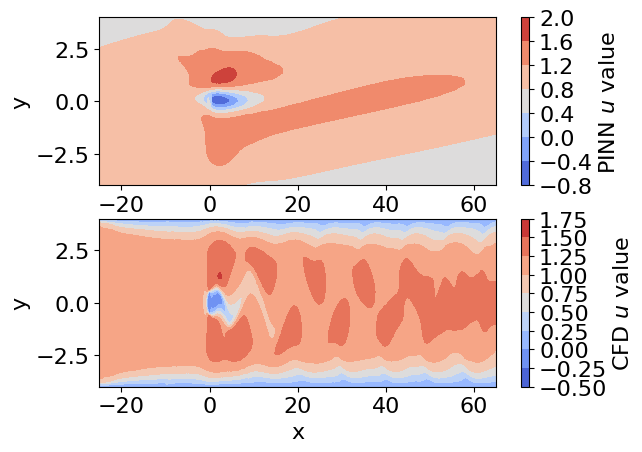

In [496]:
X1 = X_test1[:,0:1]
print("X.shape = ", X1.shape)
Y1 = X_test1[:,1:2]
print("Y.shape = ", Y1.shape)
Z_pred1 = data_pred1[:, 0:1]
print("Z_pred.shape = ", Z_pred1.shape)
Z_test1 = data_test1[:, 0:1]
print("Z_test.shape = ", Z_test1.shape)

X1 = X1.flatten()
Y1 = Y1.flatten()
Z_pred1 = Z_pred1.flatten()
Z_test1 = Z_test1.flatten()

nx1 = 10*int(np.sqrt(N1))
xg1 = np.linspace(X1.min(), X1.max(), nx1)
yg1 = np.linspace(Y1.min(), Y1.max(), nx1)

xgrid1, ygrid1 = np.meshgrid(xg1, yg1)

ctr_z_pred1 = griddata((X1, Y1), Z_pred1, (xgrid1, ygrid1), method='linear')
ctr_z_test1 = griddata((X1, Y1), Z_test1, (xgrid1, ygrid1), method='linear')

fig, axs = plt.subplots(2)
pred1 = axs[0].contourf(xgrid1, ygrid1, ctr_z_pred1, cmap=cm.coolwarm)
test1 = axs[1].contourf(xgrid1, ygrid1, ctr_z_test1, cmap=cm.coolwarm)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
cbar = fig.colorbar(pred1)
cbar.ax.set_ylabel('PINN $u$ value')

cbar = fig.colorbar(test1)
cbar.ax.set_ylabel('CFD $u$ value')

# fig.suptitle('PINN vs CFD data at t=95')

plt.savefig('comparison.eps', bbox_inches='tight', dpi=300)
plt.show()